# Variational Autoencoder
Build a variational autoencoder to work on fashion-MNIST data set. "Hands-On Machine Learning", by Aurelien Geron, is the basis for much of the code. https://github.com/ageron/handson-ml2

In [1]:
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorboard

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

%matplotlib inline

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


## 1.0 Load and Prepare Data

In [2]:
# load fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all, y_train_all), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# check the shape of the data sets
print('X_train_full shape:', X_train_all.shape)
print('y_train_full shape:', y_train_all.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train_full shape: (60000, 28, 28)
y_train_full shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [4]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
# split the data between train and validation sets, and scale

X_valid, X_train = X_train_all[:5000] / 255.0, X_train_all[5000:] / 255.0
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# also scale the X_test
X_test = X_test / 255.0

print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_valid shape: (5000, 28, 28)
y_valid shape: (5000,)
X_train shape: (55000, 28, 28)
y_train shape: (55000,)


## 2.0 Variational Autoencoder
Build the variational autoencoder. First, we will create a custom function to sample the mean and log-variables.

In [6]:
# build custom sampling function
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [7]:
# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

variational_encoder.summary()
variational_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 150)          117750      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          15100       dense[0][0]                      
______________________________________________________________________________________________

In [9]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3911 - rounded_accuracy: 0.8597 - val_loss: 0.3460 - val_rounded_accuracy: 0.8943
Epoch 2/25
55000/55000 [==============================] - 2s 36us/sample - loss: 0.3427 - rounded_accuracy: 0.8980 - val_loss: 0.3391 - val_rounded_accuracy: 0.8926
Epoch 3/25
55000/55000 [==============================] - 2s 36us/sample - loss: 0.3331 - rounded_accuracy: 0.9049 - val_loss: 0.3289 - val_rounded_accuracy: 0.9093
Epoch 4/25
55000/55000 [==============================] - 2s 36us/sample - loss: 0.3280 - rounded_accuracy: 0.9092 - val_loss: 0.3260 - val_rounded_accuracy: 0.9105
Epoch 5/25
55000/55000 [==============================] - 2s 36us/sample - loss: 0.3250 - rounded_accuracy: 0.9117 - val_loss: 0.3223 - val_rounded_accuracy: 0.9149
Epoch 6/25
55000/55000 [==============================] - 2s 36us/sample - loss: 0.3227 - rounded_accuracy: 0.9136 - val_loss:

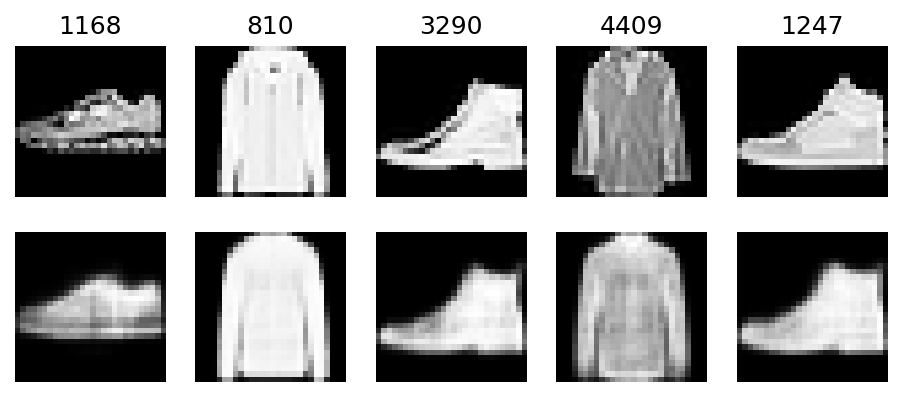

In [10]:
# plot the results
def plot_reconstructions(model, index_list, X_valid): 
    reconstructions = model.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(2, n_images,figsize=(n_images*1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        
    plt.show()

import random
index_list = random.sample(range(0,len(X_valid)), 5)
plot_reconstructions(variational_ae, index_list, X_valid)

Plot two of the latent variables on the same axis to see how they are being separated.

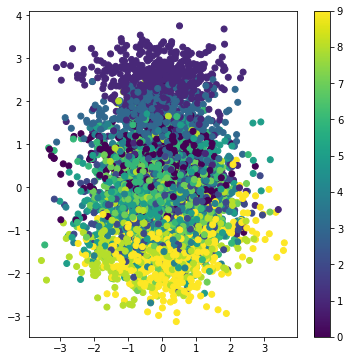

In [71]:
X_valid_encoded_ae = variational_encoder.predict(X_valid, batch_size=128)

plt.figure(figsize=(6,6))
plt.scatter(X_valid_encoded_ae[2][:,0], X_valid_encoded_ae[2][:,1], c=y_valid)
plt.colorbar()
plt.show()

Not bad! We'll use T-SNE later on to compare the VAE to the beta-VAE.

## 3.0 Disentangled Variational Autoencoder

In [11]:
# build custom sampling function
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [47]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10
beta_value = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder_beta = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder_beta = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder_beta(inputs)
reconstructions = variational_decoder_beta(codings)
variational_ae_beta = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * beta_value * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae_beta.add_loss(K.mean(latent_loss) / 784.)
variational_ae_beta.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

variational_encoder_beta.summary()
variational_decoder_beta.summary()


# make tensorboard callback and name folder
log_dir="logs/" + str('vae_') + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0,
                                                      update_freq='epoch',profile_batch=0)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 150)          117750      flatten_3[0][0]                  
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 100)          15100       dense_21[0][0]                   
____________________________________________________________________________________________

In [48]:
history = variational_ae_beta.fit(X_train, X_train, epochs=50, batch_size=128,
                             validation_data=[X_valid, X_valid],callbacks=[tensorboard_callback])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 3s 57us/sample - loss: 0.4782 - rounded_accuracy: 0.8036 - val_loss: 0.4230 - val_rounded_accuracy: 0.8398
Epoch 2/50
55000/55000 [==============================] - 2s 35us/sample - loss: 0.4183 - rounded_accuracy: 0.8540 - val_loss: 0.4036 - val_rounded_accuracy: 0.8612
Epoch 3/50
55000/55000 [==============================] - 2s 36us/sample - loss: 0.4056 - rounded_accuracy: 0.8649 - val_loss: 0.3979 - val_rounded_accuracy: 0.8731
Epoch 4/50
55000/55000 [==============================] - 2s 39us/sample - loss: 0.3993 - rounded_accuracy: 0.8698 - val_loss: 0.3917 - val_rounded_accuracy: 0.8778
Epoch 5/50
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3953 - rounded_accuracy: 0.8735 - val_loss: 0.3925 - val_rounded_accuracy: 0.8720
Epoch 6/50
55000/55000 [==============================] - 2s 43us/sample - loss: 0.3928 - rounded_accuracy: 0.8762 - val_loss:

55000/55000 [==============================] - 2s 40us/sample - loss: 0.3829 - rounded_accuracy: 0.8864 - val_loss: 0.3815 - val_rounded_accuracy: 0.8879


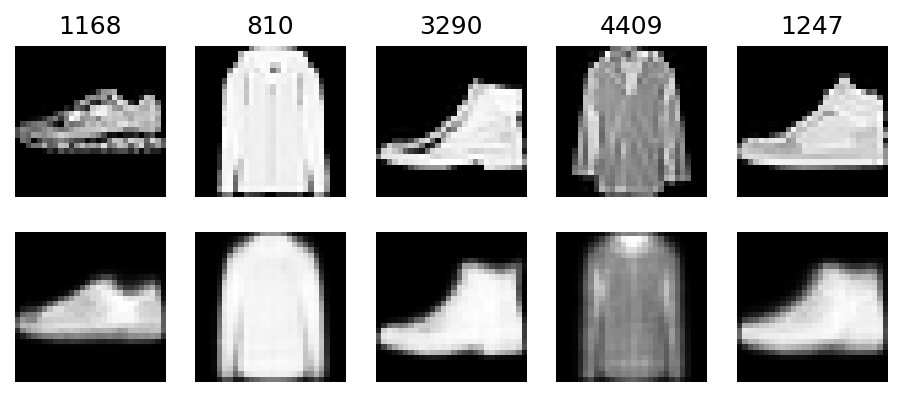

In [49]:
plot_reconstructions(variational_ae_beta, index_list, X_valid)

Let's try and cluster some of the results...

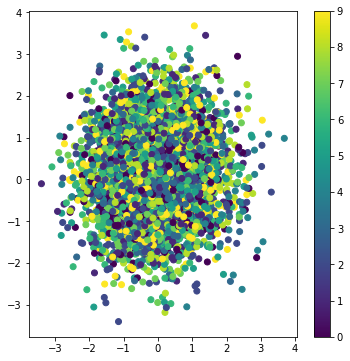

In [72]:
X_valid_encoded_beta = variational_encoder_beta.predict(X_valid, batch_size=128)

plt.figure(figsize=(6,6))
plt.scatter(X_valid_encoded_beta[2][:,0], X_valid_encoded_beta[2][:,1], c=y_valid)
plt.colorbar()
plt.show()

In [125]:
# use T-SNE
# code modified from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

from sklearn.manifold import TSNE

def encoded_2d_tsne(X_valid_encoded):
    """Returns 2D representation of the latent space via T-SNE"""
        
    np.random.seed(63)
    tsne = TSNE()
    X_valid_2D = tsne.fit_transform(X_valid_encoded[2][:,:])
    X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
    return X_valid_2D

def plot_2d_vae(X_valid_beta_2D, X_valid_ae_2D):
    fig, axes = plt.subplots(nrows=1,ncols=2,dpi=150)
    
    l = [X_valid_beta_2D, X_valid_ae_2D]
    
    i = 0
    for X_valid_2D in l:
        
        # set scatter properties https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
        axes[i].scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 
                        c=y_valid, s=10, 
                        cmap="tab10", 
                        alpha=0.5, 
                        linewidths=0, 
                        edgecolors=None)
        
        axes[i].axis('off')
        i += 1
        
    plt.show()   

In [83]:
# get the TSNE 2D embeddings
X_valid_beta_2D = encoded_2d_tsne(X_valid_encoded_beta)
X_valid_ae_2D = encoded_2d_tsne(X_valid_encoded_ae)

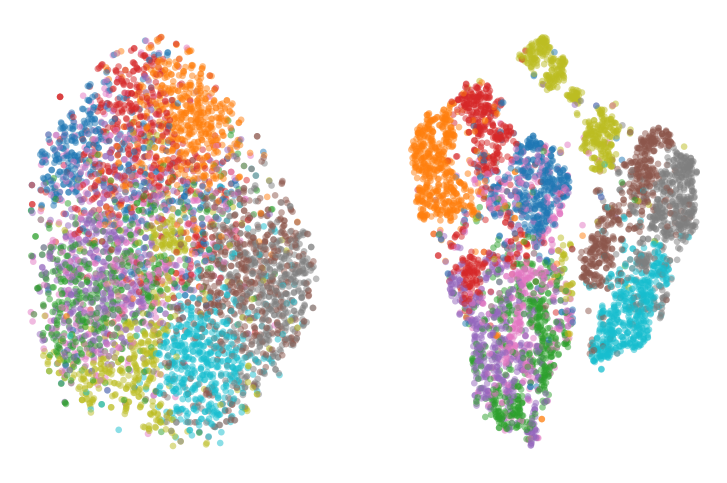

In [127]:
# plot the two different TSNE plots -- one for the beta-VAE,
# and one for the plain VAE
plot_2d_vae(X_valid_beta_2D, X_valid_ae_2D)

You can see in the above two T-SNE plots how the beta-VAE (on the left) has the latent space blending together. It is much more defined on the plain VAE (beta = 0).

Now we will look at what the latent z's look like.

In [58]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def plot_mean_z(X_valid, y_valid, variational_encoder_beta, variational_decoder_beta,class_names, title):
    
    # create a dictionary of each class of garments, and put all the 
    # latent variables (the z's) in the appropriate classes
    
    # get the latent variables (z's) -- these are from the encoder
    X_valid_latent = variational_encoder_beta(X_valid)[2].numpy()
    
    # initialize a dictionary for storing all the latent variables
    d = {}
    for i in np.arange(0,10, dtype='uint8'):
        d[i] = np.zeros(10) # an array of zeros
    
    # assign the latent variables to their appropriate classes
    for i, yi in enumerate(y_valid):
        d[yi] = np.vstack((d[yi],X_valid_latent[i]))
    
    # Customize grid with gridspec http://bit.ly/2MkqRWZ
    gs_kw = dict(width_ratios=[6,1,1], height_ratios=[8]*10,wspace=0.05,hspace=0.1)
        
    fig, axes = plt.subplots(nrows=10,ncols=3,figsize=(7,7),dpi=150,constrained_layout=False, gridspec_kw=gs_kw)
    fig.suptitle(title)

    for i in range(0, 10):          
        z_latent_mean = np.reshape(np.mean(d[i],axis=0),(1,-1))
        z_latent_example = np.reshape(d[i][random.randint(1,len(d[i]))],(1,-1))
        reconstruction_mean = variational_decoder_beta(z_latent_mean)
        reconstruction_example = variational_decoder_beta(z_latent_example)
        axes[i][0].bar(x=range(0,10),height=np.reshape(z_latent_mean,(-1)))
        axes[i][0].set_ylim((-2.5,2.5))

        # format parameters
        x_labels = [0,1,2,3,4,5,6,7,8,9]
        y_axis_label = "Class " + str(i) + "\n" + class_names[i]
        axes[i][0].set_yticks([])
        axes[i][0].tick_params(bottom=False, left=False)
        axes[i][0].get_xaxis().set_ticks(x_labels)
        axes[i][0].set_xticklabels(labels=x_labels,fontsize=8)
        axes[i][0].set_ylabel(y_axis_label,fontsize=5)
        axes[i][0].spines["top"].set_visible(False)
        axes[i][0].spines["right"].set_visible(False)
        axes[i][0].spines["left"].set_visible(False)
        
        if i == 0:
            axes[i][0].set_title("Average Latent Variables", fontsize=5)
            axes[i][1].set_title("Average Latent\nVariable\nReconstruction", fontsize=5)
            axes[i][2].set_title("Random Example\nfrom Data Set\nReconstruction", fontsize=5)
        else:
            pass
            
        if i == 9:
             #  label chart and axis
            axes[i][0].set_xlabel('Latent Variable, z', fontsize=8)
        
        if i != 9:
            axes[i][0].spines["bottom"].set_visible(False)
            
           
        else:
            pass
             
        # mean latent variable reconstruction
        axes[i][1].imshow(np.reshape(reconstruction_mean,[28,28]), cmap='viridis',)
        axes[i][1].axis('off')
        
        # example of a single reconstruction
        axes[i][2].imshow(np.reshape(reconstruction_example,[28,28]), cmap='viridis')
        axes[i][2].axis('off')
        
    plt.show()

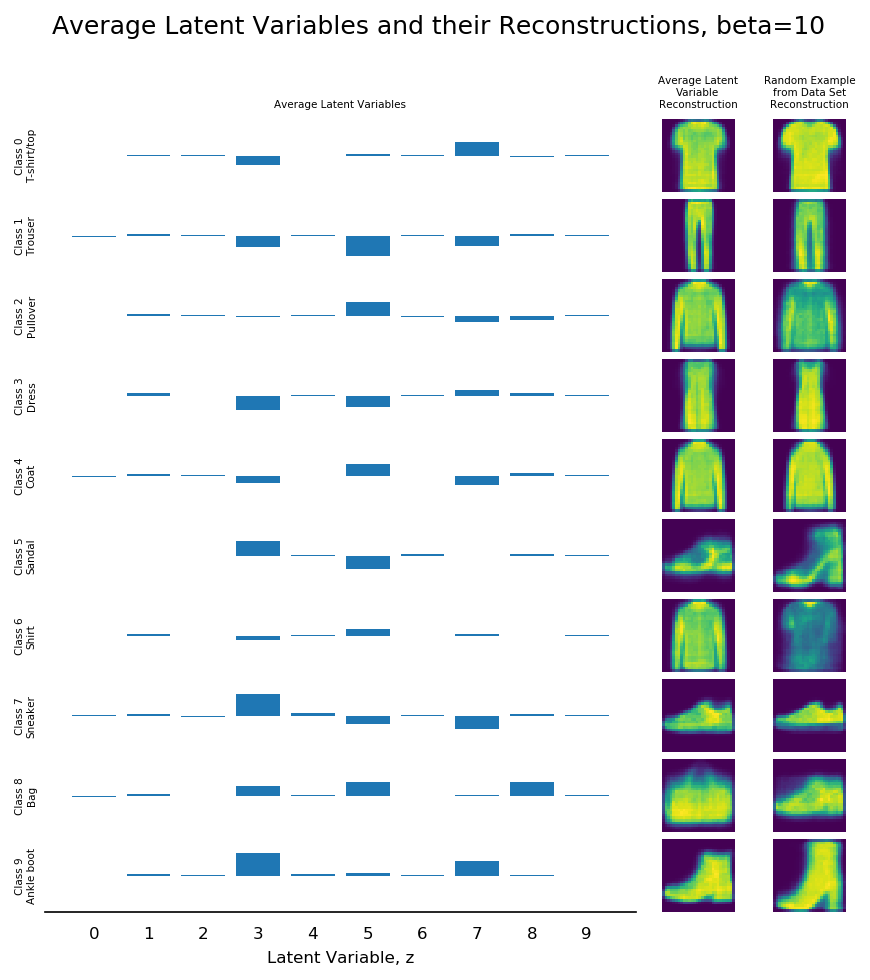

In [61]:
plot_mean_z(X_valid, y_valid, 
            variational_encoder_beta, 
            variational_decoder_beta,
            class_names, 
            "Average Latent Variables and their Reconstructions, beta=10")

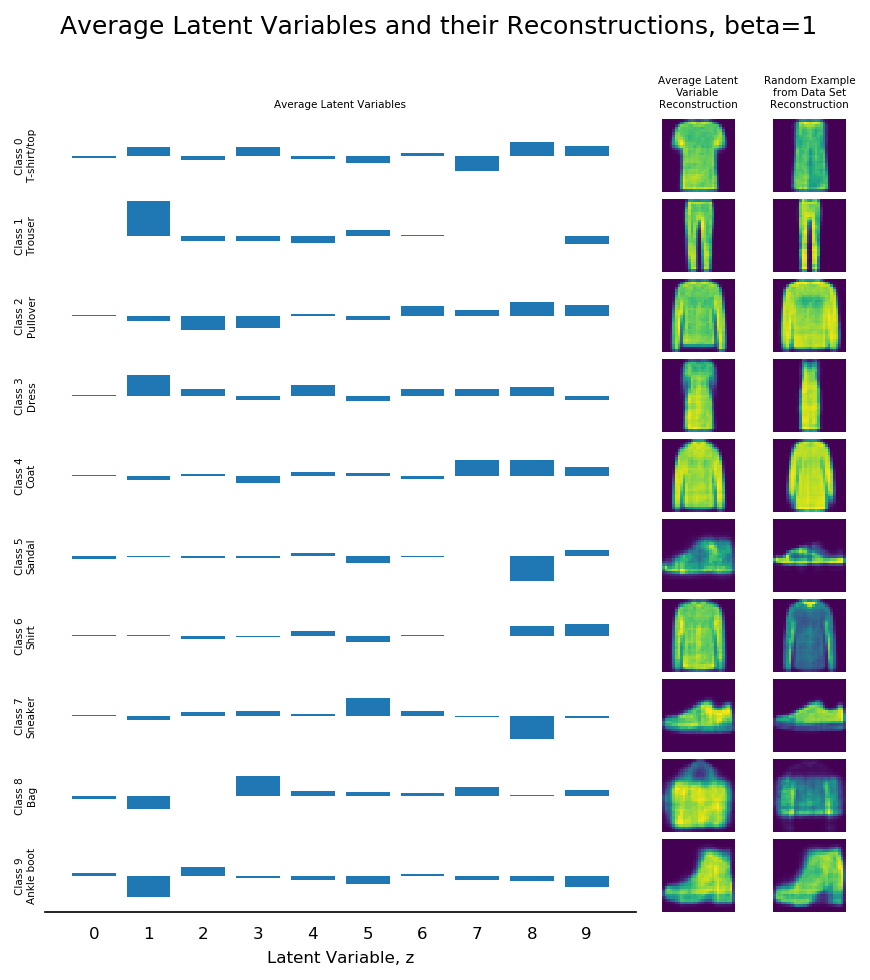

In [62]:
plot_mean_z(X_valid, y_valid, 
            variational_encoder, 
            variational_decoder, 
            class_names, 
            "Average Latent Variables and their Reconstructions, beta=1")

The big thing that is noticed in the two plots above, is that for when beta=10, there are fewer latent variables being utilized. The reconstruction images are also more of a blend of others.

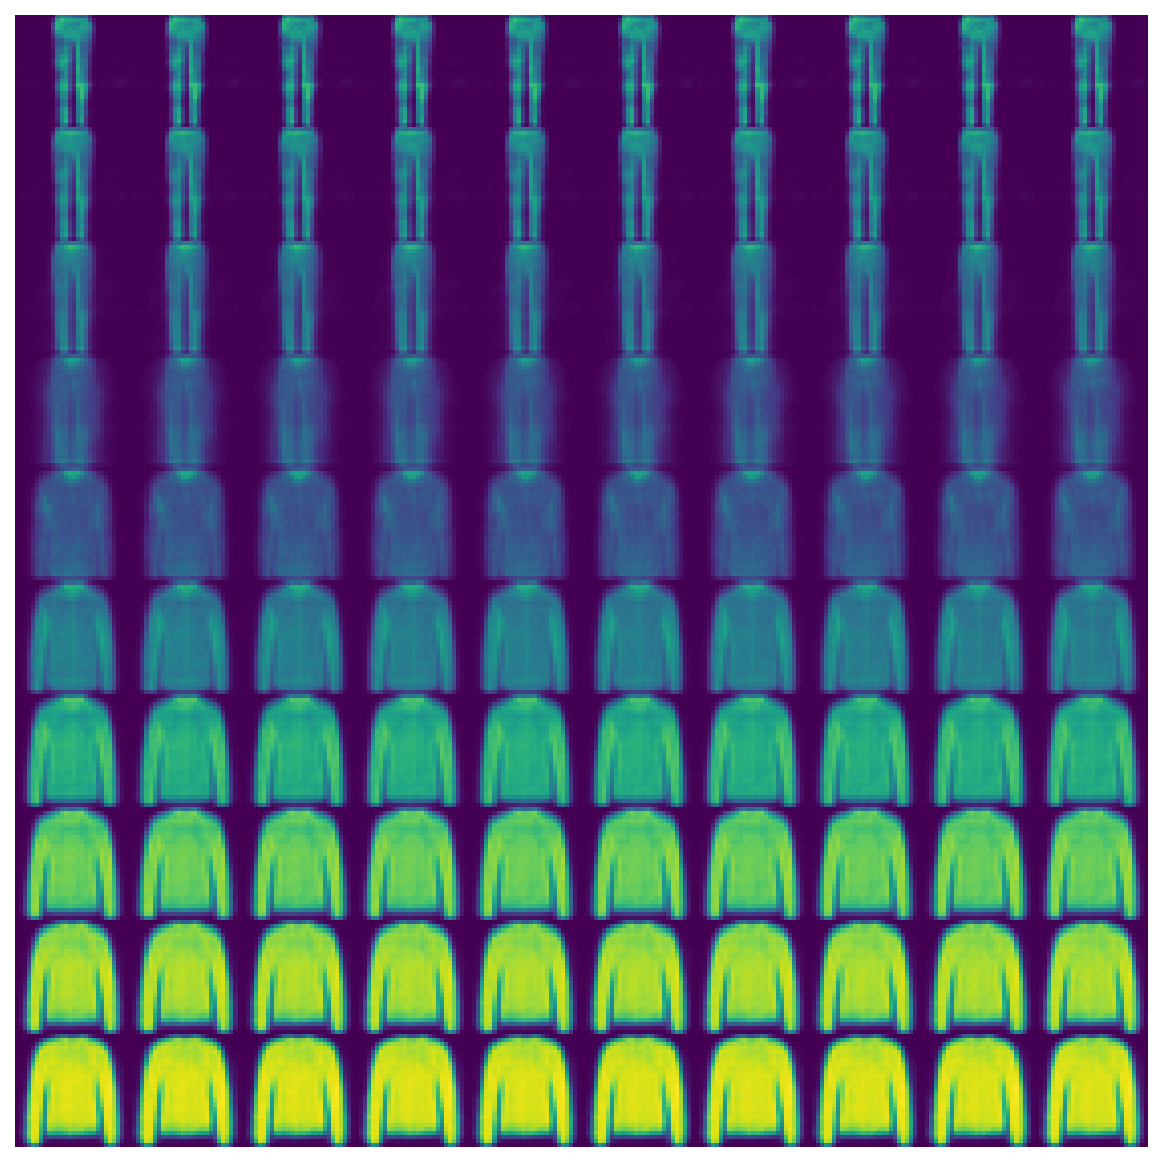

In [130]:
# another way to visualize
# code adapted from Hamidreza Saghir at https://github.com/hsaghir/VAE_intuitions
from scipy.stats import norm
n=10
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))

grid_x = np.arange(-3,3.2, 6/9, dtype='float32')
grid_y = grid_x

for i, yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample=np.array([[0,0,xi,0,0,yi,0,0,0,0]])
        x_decoded=variational_decoder_beta(z_sample)
        digit=np.reshape(x_decoded,[28,28])
        figure[i*digit_size:(i+1)*digit_size, 
              j*digit_size:(j+1)*digit_size]=digit
        
plt.figure(figsize=(10,10), dpi=150)
plt.imshow(figure, cmap='viridis')
plt.axis('off')
plt.show()